# Bill Cobb's Vehicle Dynamics Professionals' July 2024 Challenge - #4

Given the results of a constant speed understeer test, compute the understeer
gradient and cornering compliance evolution with lateral acceleration. The
vehicle is an FSAE car with non-linear steering and non-linear tires simulated
with Bill Cobb's BZ3 simulation program.

The original challenge text from reads as follows:

> Now try a Constant Speed Ramp Steer test on a Whizz Bang FSAE car. It has some special attention to front Ackermann that is quite useful for maximizing total grip levels and a reversed TLLTD. Still has a gross nonlinear steering system and my Pacejka5 tire model for Fy & Mz. Parameters needed to complete the summary are in the title line (same as the other 3 test cases).


In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy as sp

In [3]:
plt.style.use("seaborn-v0_8")

## Part 1: Define Constants

We are given known quantities of the vehicle under test. Define them as constants.


In [4]:
VEHICLE_WB = 1.745  # m
VEHICLE_SR = 5.0  # rad/rad
VEHICLE_WF = 80  # kg
VEHICLE_WR = 120  # kg
VEHICLE_M = VEHICLE_WF + VEHICLE_WR
VEHICLE_LA = VEHICLE_WB * (VEHICLE_WR / VEHICLE_M)
VEHICLE_LB = VEHICLE_WB * (VEHICLE_WF / VEHICLE_M)

Use constants for column header names to make it easier to access.


In [5]:
# Provided columns
COLUMN_TIME = "TIME, sec"
COLUMN_LATACC = "LATACC, g"
COLUMN_BETA = "SIDSLP, deg"
COLUMN_SPEED = "SPEED, kph"
COLUMN_STEER = "STEER, deg"

# Computed columns
COLUMN_LATACC_SI = "LATACC, m/s^2"
COLUMN_BETA_SI = "BETA, rad"
COLUMN_SPEED_SI = "SPEED, m/s"
COLUMN_STEER_SI = "STEER, rad"
COLUMN_DELTA = "DELTA, deg"
COLUMN_DELTA_SI = "DELTA, rad"

# Math channels
COLUMN_DF = "DF, rad/G"
COLUMN_DR = "DR, rad/G"
COLUMN_USG = "USG, rad/G"

Define common conversion factors.


In [6]:
STD_G = 9.81
DEG2RAD = np.pi / 180.0
RAD2DEG = 1 / DEG2RAD
KPH2MPS = 1000 / 3600.0
MPS2KPH = 1 / KPH2MPS
M2FT = 3.28084

## Part 2: Data Wrangling


### Load in the data


Read in the data and sanitize it for consumption. The data has the following form:

| Row number | Description                                                                       | Sample                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| ---------- | --------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Line 1     | Comment header describing the contents of the CSV and relevant vehicle parameters | `"BZ3 Nonlinear Vehicle Dynamics Simulation SR= 5.00 WB=1745 mm  WF=80   WR=120  "`                                                                                                                                                                                                                                                                                                                                                     |
| Line 2     | Column header names and units                                                     | `"TIME, sec";"LATACC, g";"SIDSLP, deg";"SPEED, kph";"STEER, deg";                                                                                                                                                                                                                                                                                                                                                                    ;` |
| Line 3+    | Time series data                                                                  | `0.060    ;0.006    ;0.002    ;80.000   ;0.125     `                                                                                                                                                                                                                                                                                                                                                                                    |


In [7]:
FILE_PATH = "../data/marc4.txt"

In [8]:
df = pl.read_csv(FILE_PATH, skip_rows=1, columns=range(5), separator=";").with_columns(
    pl.col("*").str.extract(r"(^-?\d+[.\d]*)").str.to_decimal()
)
df

"TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]"
0.000,0.000,0.000,80.000,0.000
0.010,0.001,0.000,80.000,0.021
0.020,0.002,0.000,80.000,0.042
0.030,0.003,0.001,80.000,0.062
0.040,0.004,0.001,80.000,0.083
…,…,…,…,…
11.960,2.691,-4.120,80.000,24.917
11.970,2.692,-4.131,80.000,24.937
11.980,2.694,-4.141,80.000,24.958


### Convert to SI units

Perform all calculations in SI units.


In [9]:
df = df.with_columns(
    (pl.col(COLUMN_LATACC).cast(pl.Float32) * STD_G).alias(COLUMN_LATACC_SI),
    (pl.col(COLUMN_BETA).cast(pl.Float32) * DEG2RAD).alias(COLUMN_BETA_SI),
    (pl.col(COLUMN_SPEED).cast(pl.Float32) * KPH2MPS).alias(COLUMN_SPEED_SI),
    (pl.col(COLUMN_STEER).cast(pl.Float32) * DEG2RAD).alias(COLUMN_STEER_SI),
    (pl.col(COLUMN_STEER).cast(pl.Float32) / VEHICLE_SR).alias(COLUMN_DELTA),
    (pl.col(COLUMN_STEER).cast(pl.Float32) * DEG2RAD / VEHICLE_SR).alias(
        COLUMN_DELTA_SI
    ),
)
df

"TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","DELTA, deg","DELTA, rad"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32
0.000,0.000,0.000,80.000,0.000,0.0,0.0,22.222223,0.0,0.0,0.0
0.010,0.001,0.000,80.000,0.021,0.00981,0.0,22.222223,0.000367,0.0042,0.000073
0.020,0.002,0.000,80.000,0.042,0.01962,0.0,22.222223,0.000733,0.0084,0.000147
0.030,0.003,0.001,80.000,0.062,0.02943,0.000017,22.222223,0.001082,0.0124,0.000216
0.040,0.004,0.001,80.000,0.083,0.03924,0.000017,22.222223,0.001449,0.0166,0.00029
…,…,…,…,…,…,…,…,…,…,…
11.960,2.691,-4.120,80.000,24.917,26.39871,-0.071908,22.222223,0.434884,4.9834,0.086977
11.970,2.692,-4.131,80.000,24.937,26.40852,-0.0721,22.222223,0.435233,4.9874,0.087047
11.980,2.694,-4.141,80.000,24.958,26.428141,-0.072274,22.222223,0.435599,4.9916,0.08712


### Visualize provided data

Plot the timeseries to see what we are working with.


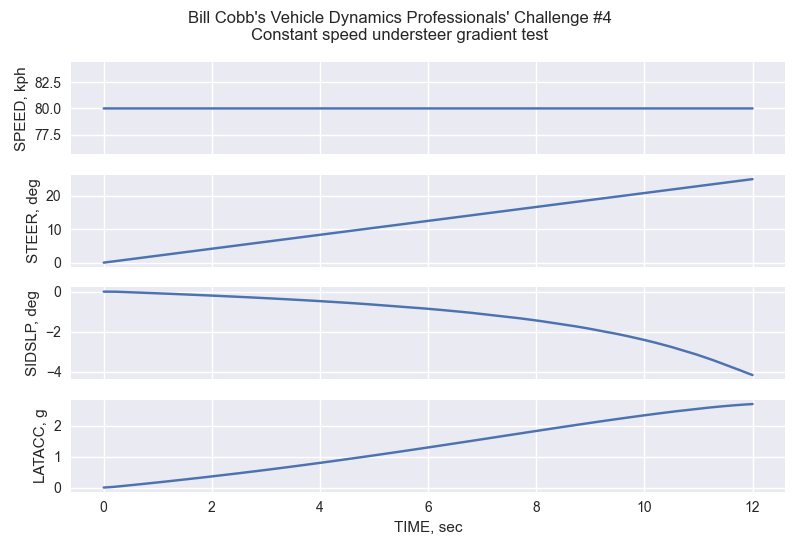

In [10]:
fig, axes = plt.subplots(4, 1, sharex=True)

# Plot
columns = [COLUMN_SPEED, COLUMN_STEER, COLUMN_BETA, COLUMN_LATACC]
for ax, col in zip(axes, columns):
    ax.plot(df[COLUMN_TIME], df[col])
    ax.set_ylabel(col)

# Labels
axes[-1].set_xlabel(COLUMN_TIME)

# Title
fig.suptitle(
    "Bill Cobb's Vehicle Dynamics Professionals' Challenge #4\nConstant speed understeer gradient test"
)

plt.tight_layout()
plt.show()

## Part 3: Data Exploration


As a constant speed understeer gradient test, what is the test speed?


In [11]:
vehicle_speed = df[COLUMN_SPEED_SI].median()
print(f"Vehicle speed: {vehicle_speed:.2f} m/s")
print(f"Vehicle speed: {vehicle_speed * MPS2KPH:.2f} km/h")

Vehicle speed: 22.22 m/s
Vehicle speed: 80.00 km/h


## Part 4: Extract metrics

From a constant speed understeer gradient test, we can compute the understeer
gradient from the measured steering response and the rear cornering compliance
from the measured sideslip response by subtracting the geometric terms from the
gradients.


### Helper functions

Place boilerplate reusable code before we begin our computation.


In [12]:
def gradient(x, y, s=0.0):
    """Compute gradients by fitting a smoothing spline to the data."""
    f = sp.interpolate.splrep(x, y, s=s)
    return sp.interpolate.splev(x, f, der=1)


def interpolate(x, y, xeval):
    """Interpolate x and y at xeval"""
    f = sp.interpolate.CubicSpline(x, y)
    return f(xeval)

### Understeer gradient

The understeer gradient is a gain on lateral acceleration that modifies the required road wheel angle to meet a specified corner radius. Recall:

$$ \delta = \frac{L}{R} + Ka_y $$

The corner radius can be calculated from the vehicle lateral acceleration.

$$ a_y = \frac{u^2}{R} $$

Substituting, the understeer gradient equation becomes the following.

$$ \delta = \left(\frac{L}{u^2} + K \right) a_y $$

Implicitly differentiating and solving for the understeer gradient.

$$ K = \frac{d\delta}{da_y} - \frac{L}{u^2} $$


In [13]:
# With units of rad/G
smooth_factor = 0.01
df = df.with_columns(
    pl.Series(
        name=COLUMN_USG,
        values=STD_G
        * (
            gradient(df[COLUMN_LATACC_SI], df[COLUMN_DELTA_SI], s=smooth_factor)
            - (VEHICLE_WB / df[COLUMN_SPEED_SI] ** 2)
        ),
    )
)
df

"TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","DELTA, deg","DELTA, rad","USG, rad/G"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f64
0.000,0.000,0.000,80.000,0.000,0.0,0.0,22.222223,0.0,0.0,0.0,0.009073
0.010,0.001,0.000,80.000,0.021,0.00981,0.0,22.222223,0.000367,0.0042,0.000073,0.009051
0.020,0.002,0.000,80.000,0.042,0.01962,0.0,22.222223,0.000733,0.0084,0.000147,0.009029
0.030,0.003,0.001,80.000,0.062,0.02943,0.000017,22.222223,0.001082,0.0124,0.000216,0.009006
0.040,0.004,0.001,80.000,0.083,0.03924,0.000017,22.222223,0.001449,0.0166,0.00029,0.008984
…,…,…,…,…,…,…,…,…,…,…,…
11.960,2.691,-4.120,80.000,24.917,26.39871,-0.071908,22.222223,0.434884,4.9834,0.086977,0.00328
11.970,2.692,-4.131,80.000,24.937,26.40852,-0.0721,22.222223,0.435233,4.9874,0.087047,0.003298
11.980,2.694,-4.141,80.000,24.958,26.428141,-0.072274,22.222223,0.435599,4.9916,0.08712,0.003335


### Rear cornering compliance

From first principles, cornering compliance is the steady-state change in slip
angle with respect to lateral acceleration.

$$ D = -\frac{d\alpha}{da_y}$$

The slip angle of the rear axle in steady-state is the summation of the side
slip angle $\beta$ and the geometric component induced by the yaw velocity.
Assuming in SAE J670 coordinates.

$$ \alpha_r = \beta - \frac{l_b a_y}{u^2} $$

Implicitly differentiating knowing that vehicle speed is constant.

$$ d\alpha_r = d\beta - \frac{l_b da_y}{u^2} $$
$$ \frac{d\alpha_r}{da_y} = \frac{d\beta}{da_y} - \frac{l_b}{u^2} $$

The rear cornering compliance the derived to be as follows.

$$ D_r = \frac{l_b}{u^2} - \frac{d\beta}{da_y} $$


In [14]:
# With units of rad/G
smooth_factor = 0.01
df = df.with_columns(
    pl.Series(
        name=COLUMN_DR,
        values=STD_G
        * (
            (VEHICLE_LB / df[COLUMN_SPEED_SI] ** 2)
            - gradient(df[COLUMN_LATACC_SI], df[COLUMN_BETA_SI], s=smooth_factor)
        ),
    )
)
df

"TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","DELTA, deg","DELTA, rad","USG, rad/G","DR, rad/G"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f64,f64
0.000,0.000,0.000,80.000,0.000,0.0,0.0,22.222223,0.0,0.0,0.0,0.009073,0.035693
0.010,0.001,0.000,80.000,0.021,0.00981,0.0,22.222223,0.000367,0.0042,0.000073,0.009051,0.035662
0.020,0.002,0.000,80.000,0.042,0.01962,0.0,22.222223,0.000733,0.0084,0.000147,0.009029,0.035631
0.030,0.003,0.001,80.000,0.062,0.02943,0.000017,22.222223,0.001082,0.0124,0.000216,0.009006,0.0356
0.040,0.004,0.001,80.000,0.083,0.03924,0.000017,22.222223,0.001449,0.0166,0.00029,0.008984,0.035569
…,…,…,…,…,…,…,…,…,…,…,…,…
11.960,2.691,-4.120,80.000,24.917,26.39871,-0.071908,22.222223,0.434884,4.9834,0.086977,0.00328,0.087965
11.970,2.692,-4.131,80.000,24.937,26.40852,-0.0721,22.222223,0.435233,4.9874,0.087047,0.003298,0.088035
11.980,2.694,-4.141,80.000,24.958,26.428141,-0.072274,22.222223,0.435599,4.9916,0.08712,0.003335,0.088174


### Front cornering compliance

Recall that the understeer gradient is the difference between front and rear cornering compliances.

$$ K = D_f - D_r $$

Therefore.

$$ D_f = D_r + K $$


In [15]:
df = df.with_columns((pl.col(COLUMN_DR) + pl.col(COLUMN_USG)).alias(COLUMN_DF))
df

"TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","DELTA, deg","DELTA, rad","USG, rad/G","DR, rad/G","DF, rad/G"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f64,f64,f64
0.000,0.000,0.000,80.000,0.000,0.0,0.0,22.222223,0.0,0.0,0.0,0.009073,0.035693,0.044766
0.010,0.001,0.000,80.000,0.021,0.00981,0.0,22.222223,0.000367,0.0042,0.000073,0.009051,0.035662,0.044713
0.020,0.002,0.000,80.000,0.042,0.01962,0.0,22.222223,0.000733,0.0084,0.000147,0.009029,0.035631,0.04466
0.030,0.003,0.001,80.000,0.062,0.02943,0.000017,22.222223,0.001082,0.0124,0.000216,0.009006,0.0356,0.044606
0.040,0.004,0.001,80.000,0.083,0.03924,0.000017,22.222223,0.001449,0.0166,0.00029,0.008984,0.035569,0.044553
…,…,…,…,…,…,…,…,…,…,…,…,…,…
11.960,2.691,-4.120,80.000,24.917,26.39871,-0.071908,22.222223,0.434884,4.9834,0.086977,0.00328,0.087965,0.091245
11.970,2.692,-4.131,80.000,24.937,26.40852,-0.0721,22.222223,0.435233,4.9874,0.087047,0.003298,0.088035,0.091333
11.980,2.694,-4.141,80.000,24.958,26.428141,-0.072274,22.222223,0.435599,4.9916,0.08712,0.003335,0.088174,0.091509


## Part 5: Visualize

Plot all the results into a figure and present the results.


In [16]:
FIG_SCALE = 0.66

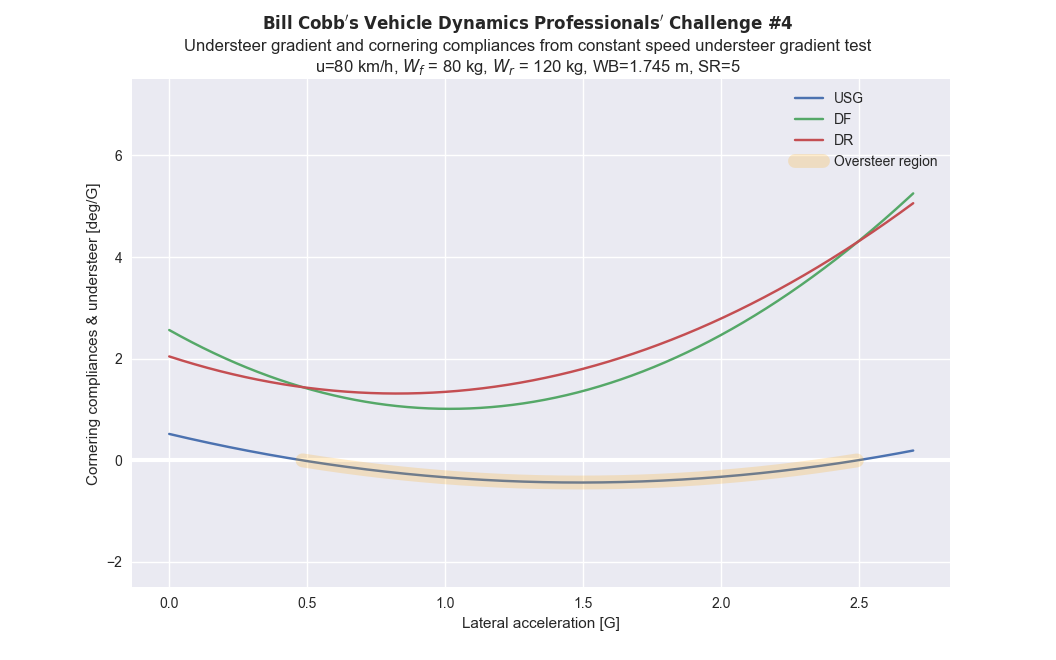

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16*FIG_SCALE, 10*FIG_SCALE))

ax.plot(
    df[COLUMN_LATACC],
    df[COLUMN_USG, COLUMN_DF, COLUMN_DR] * RAD2DEG,
    label=["USG", "DF", "DR"],
)
ax.plot(
    df.filter(pl.col(COLUMN_USG) < 0)[COLUMN_LATACC],
    df.filter(pl.col(COLUMN_USG) < 0)[COLUMN_USG] * RAD2DEG,
    color="orange",
    linewidth=10,
    alpha=0.2,
    label=["Oversteer region"]
)

ax.axhline(0, color="white", linewidth=3, zorder=0)
ax.set_ylim(bottom=-2.5, top=7.5)
ax.set_xlabel("Lateral acceleration [G]")
ax.set_ylabel("Cornering compliances & understeer [deg/G]")
ax.legend()

fig.suptitle(
    r"$\mathbf{Bill\ Cobb's\ Vehicle\ Dynamics\ Professionals'\ Challenge\ \#4}$"
    + "\n"
    + "Understeer gradient and cornering compliances from constant speed understeer gradient test"
    + "\n"
    + f"u={vehicle_speed*MPS2KPH:.0f} km/h, "
    + r"$W_f$ = 80 kg, $W_r$ = 120 kg, WB=1.745 m, SR=5"
)

plt.tight_layout
plt.show()